In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("drive/My Drive/Colab Notebooks/Structural/Project")

Mounted at /content/drive


Dataset Preparation and Split

In [ ]:
dataset = pd.read_csv('./data/dataset.ultrafltr.csv')
print(dataset)

                                              sequence                                          opm_class
0    SGFEFHGYARSGVIMNDSGASTKSGAYITPAGETGGAIGRLGNQAD...  0000111111111111000000000000000000000000000001...
1    MASMTGGQQMGRDLQVTLYGTIKAGVEVSRVKDAGTYKAQGGKSKT...  0000000000000001111111111111000000000000000000...
2    GTMARNDGQGKAAATFMHISYNNFITEVDNLNKRMGDLRDINGEAG...  0000000000000000000000000000000000000000000011...
3    VDFHGYARSGIGWTGSGGEQQCFQTTGAQSKYRLGNECETYAELKL...  0111111111111000000000000000000000000011111111...
4    ANSGEAPKNFGLDVKITGESENDRDLGTAPGGTLNDIGIDLRPWAF...  0000000011111111111100000000000000011111111111...
..                                                 ...                                                ...
223  MWEANELSSTNTFSHQAEMDWPSANWWQRYQDAQLNHLIEEALQHS...  0000000000000000000000000000000000000000000000...
224  AGLVVNDNDLRNDLAWLSDRGVIHLSLSTWPLSQEEIARALKKAKP...  0000000000000000000000000000000000000000000000...
225  QDTSPDTLVVTANRFEQPRSTVLAPTTVVTRQDIDRWQSTS

Lengths of sequences

(array([75., 89., 49., 13.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 105. ,  334.8,  564.6,  794.4, 1024.2, 1254. , 1483.8, 1713.6,
        1943.4, 2173.2, 2403. ]),
 <a list of 10 Patch objects>)

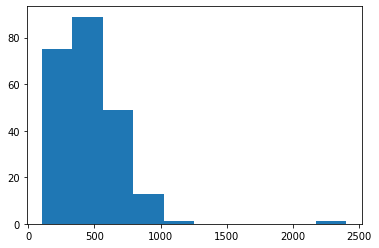

In [ ]:
data = dataset['sequence'].str.len()
counts, bins = np.histogram(data)
plt.hist(bins[:-1], bins, weights=counts)

(226, 2)


(array([16., 17., 54., 41., 26., 13., 14., 23., 14.,  8.]),
 array([105. , 185.8, 266.6, 347.4, 428.2, 509. , 589.8, 670.6, 751.4,
        832.2, 913. ]),
 <a list of 10 Patch objects>)

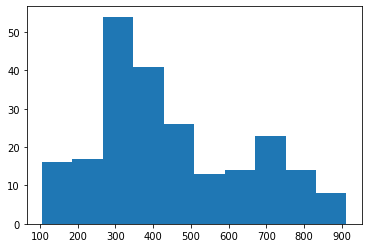

In [ ]:
df_filtered = dataset[dataset['sequence'].str.len() <= 1000]
print(df_filtered.shape)

data = df_filtered['sequence'].str.len()
counts, bins = np.histogram(data)
plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
dataset = df_filtered
measurer = np.vectorize(len)
res1 = measurer(dataset.values.astype(str)).max(axis=0)[0]
print(res1)

df, df_test = train_test_split(dataset, test_size=0.1)
print(df)

913
                                              sequence                                          opm_class
18   AQAEASSAQAAQQKNFNIAAQPLQSAMLRFAEQAGMQVFFDEVKLD...  0000000000000000000000000000000000000000000000...
25   ANVRLQHHHHHHHLEEFIADSKAELTLRNFYFDRDYKKDPYPYTAA...  0000000000000000000000111111111000000000000000...
13   MAPKDNTWYTGAKLGWSQYHDTGLINNNGPTHENKLGAGAFGGYQV...  0000000111111111000000000000000000011111111110...
36   DAGTVDFYGQLRTELKFLEDKDPTIGSGSSRAGVDANYTVNDSLAL...  0001111111111111000000000000000111111100000001...
217  ENLMQVYQQARLSNPELRKSAADRDAAFEKINEARSPLLPQLGLGA...  0000000000000000000000000000000000000000111111...
..                                                 ...                                                ...
78   DNVITRVVAVRNVSVRELSPLLRQLIDNAGAGNVVHYDPANIILIT...  0000000000000000000000000000000000000000000000...
218  MNSSRSVNPRPSFAPRALSLAIALLLGAPAFAANSGEAPKNFGLDV...  0000000000000000000000000000000000000000111111...
110  CTMIPQYEQPKVEVAETFQNDTSVSSIRAVDLGWHDY

Encoding of Aminoacids

In [ ]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1
    return char_dict
char_dict = create_dict(codes)

def integer_encoding(data):
    """
    - Encodes code sequence to integer values.
    - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
    """
    row_encode = []
    for code in list(data):
        row_encode.append(char_dict.get(code, 0))
    return row_encode

Model

In [ ]:
# prepare data for the LSTM
def get_dataset(df):
    X1, X2, y = list(), list(), list()

    
    for index, row in df.iterrows():
        # generate source sequence
        source = row['sequence']
        # source = source.ljust(res1, '0')
        source = integer_encoding(source)

        # define padded target sequence
        target = row['opm_class']
        # target = target.ljust(res1, '0')
        target = list(map(int, target))

        # create padded input target sequence
        target_in = [0] + target[:-1]

        # encode
        src_encoded = to_categorical(source, num_classes=20+1)
        tar_encoded = to_categorical(target, num_classes=2)
        tar2_encoded = to_categorical(target_in, num_classes=2)


        # store
        X1.append(src_encoded)
        X2.append(tar2_encoded)
        y.append(tar_encoded)

    return array(X1), array(X2), array(y)#, temp_df
    
# Creating the first Dataframe using dictionary
X1, X2, y = get_dataset(df)
X1 = pad_sequences(X1, maxlen=res1, padding='post', truncating='post')
X2 = pad_sequences(X2, maxlen=res1, padding='post', truncating='post')
y = pad_sequences(y, maxlen=res1, padding='post', truncating='post')


# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
	# define training encoder
	encoder_inputs = Input(shape=(None, n_input))
	encoder = LSTM(n_units, return_state=True)
	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
	encoder_states = [state_h, state_c]
	# define training decoder
	decoder_inputs = Input(shape=(None, n_output))
	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units,))
	decoder_state_input_c = Input(shape=(n_units,))
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
	# return all models
	return model, encoder_model, decoder_model

train, infenc, infdec = define_models(20+1, 2, 128)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train.summary()

# train model
train.fit([X1, X2], y, epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, None, 21)]   0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 128), (None, 76800       input_17[0][0]                   
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, None, 128),  67072       input_18[0][0]                   
                                                                 lstm_8[0][1]              

Prediction

In [ ]:
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

def compare_seqs(source, target):
    correct = 0
    for i in range(len(source)):
        if source[i] == target[i]:
            correct += 1
    
    return correct

# generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)

    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    return array(output)

# evaluate LSTM
X1, X2, y = get_dataset(df_test)
X1 = pad_sequences(X1, maxlen=res1, padding='post', truncating='post')
X2 = pad_sequences(X2, maxlen=res1, padding='post', truncating='post')
y = pad_sequences(y, maxlen=res1, padding='post', truncating='post')

accuracies = []
for i in range(len(X1)):
    row = X1[i]
    row = row.reshape((1, row.shape[0], row.shape[1]))
    target = predict_sequence(infenc, infdec, row, res1, 2)

    curr_acc = compare_seqs(one_hot_decode(target), one_hot_decode(y[i]))/res1
    accuracies.append(curr_acc)

    print(f'Sequence{i} Accuracy: {curr_acc}')

total_acc = 0
for i in range(len(accuracies)):
    total_acc += accuracies[i]
print('Total Accuracy: %.2f%%' % (float(total_acc)/float(len(X1))*100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Sequence0 Accuracy: 0.8499452354874042
Sequence1 Accuracy: 0.8335158817086528
Sequence2 Accuracy: 0.8433734939759037
Sequence3 Accuracy: 0.9518072289156626
Sequence4 Accuracy: 0.8313253012048193
Sequence5 Accuracy: 0.8751369112814896
Sequence6 Accuracy: 0.9693318729463308
Sequence7 Accuracy: 0.7995618838992333
Sequence8 Accuracy: 0.8433734939759037
Sequence9 Accuracy: 0.9079956188389924
Sequence10 Accuracy: 0.976998904709748
Sequence11 Accuracy: 0.8488499452354874
Sequence12 Accuracy: 0.787513691128149
Sequence13 Accuracy: 0.8411829134720701
Sequence14 Accuracy: 0.8554216867469879
Sequence15 Accuracy: 0.8663745892661555
Sequence16 Accuracy: 0.9507119386637459
Sequence17 Accuracy: 0.7842278203723987
Sequence18 Accuracy: 0.8696604600219058
Sequence19 Accuracy: 0.7710843373493976
Sequence20 Accuracy: 0.9178532311062432
Sequence21 Accuracy: 0.9167579408543264
Sequence22 Accuracy: 0.8674698795180723
Total Accuracy: 86.78%
